1. Installing and Importing Python Libraries and Dependencies

In [ ]:
!pip install geopy
# !pip install geocoder
!pip install folium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
# from geopy.geocoders import Nominatim 
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


**2. Data Extraction and Cleaning**

Converting content of PostalCode HTML table as dataframe

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tabulate import tabulate

url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
res = requests.get(url)
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df_list = pd.read_html(str(table))
df = pd.concat(df_list)
# df.head(5)

In [ ]:
df['col']=df[df.columns[0:]].apply(lambda x: '*'.join(x.dropna().astype(str)),axis=1)
res=df.set_index([0,1,2,3,4,5,6,7,8]).apply(lambda x:x.str.split('*').explode()).reset_index()
df1=pd.DataFrame(res)
df1=df1.drop([0,1,2,3,4,5,6,7,8],axis=1)
# df1.count()

In [ ]:
df1['Postalcode'] = df1['col'].str.extract(r'^(\w{3})')
df1['Borough'] = df1['col'].str.extract(r'^.{3}(.+)\(')
df1['Neighborhood'] = df1['col'].str.extract(r'\((.*?)\)', expand=True)
df1['Neighborhood'] = df1['Neighborhood'].str.split(' / ').apply(lambda x: ', '.join(x[::-1]) if isinstance(x, list) else '')
df1.dropna(subset=['Borough'], inplace=True)
del df1['col']
print(df1.shape)
df1.head(3)

(103, 3)


,Postalcode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Harbourfront, Regent Park"


In [ ]:
df1.describe()

,Postalcode,Borough,Neighborhood
count,103,103,103
unique,103,17,98
top,M3A,North York,Downsview
freq,1,22,4


In [ ]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.708840259000056, -79.36614405899996]

In [ ]:
# Retrieving Postal Code Co-ordinates
postal_codes = df1['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [ ]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df1['Latitude'] = df_coords['Latitude']
df1['Longitude'] = df_coords['Longitude']
df1[df1.Postalcode == 'M5G']

,Postalcode,Borough,Neighborhood,Latitude,Longitude
40,M5G,Downtown Toronto,Central Bay Street,43.738945,-79.470945


In [ ]:
df1.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
2,M3A,North York,Parkwoods,43.655208,-79.363013
3,M4A,North York,Victoria Village,43.722074,-79.450524
4,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.662300,-79.389293
5,M6A,North York,"Lawrence Heights, Lawrence Manor",43.666326,-79.528447
6,M7A,Queen's Park,Ontario Provincial Government,43.809240,-79.193050


In [ ]:
from geopy.geocoders import Nominatim

address = 'Scarborough,Toronto'
geolocator = Nominatim(user_agent="Capstone_Project-The_Battle_of_Neighborhoods")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Seattle,Washington are {}, {}.'.format(latitude_x, longitude_y))


The Geograpical Co-ordinate of Seattle,Washington are 43.7729744, -79.2576479.


**3. Map of Scarborough**

In [ ]:
df1.dropna(subset=['Latitude', 'Longitude'], inplace=True)
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df1['Latitude'], df1['Longitude'], df1['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough


In [ ]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent="Capstone_Project-The_Battle_of_Neighborhoods")
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 43.7729744, -79.2576479.


In [ ]:

CLIENT_ID = 'Y14HQSNBJ0HCPXNMWLYXJN4NEZFG2DJBABBP4MFAUKLL5DOO' # my Foursquare ID
CLIENT_SECRET = 'QHVO3KVESS0EWBFRWLNL4HCKT2GIFFI2ZMGJMU1JD3YQYJLX' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: Y14HQSNBJ0HCPXNMWLYXJN4NEZFG2DJBABBP4MFAUKLL5DOO
CLIENT_SECRET: QHVO3KVESS0EWBFRWLNL4HCKT2GIFFI2ZMGJMU1JD3YQYJLX


In [ ]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [ ]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups', 'venue.createdAt',
       'venue.location.neighborhood', 'venue.events.count',
       'venue.events.summary', 'venue.venuePage.id'],
      dtype='object')

In [ ]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


**4. Nearby Venues/Locations**

In [ ]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,American Eagle Store,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776012,-79.258334
1,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
2,Shoppers Drug Mart,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",43.773305,-79.251662
3,Coliseum Scarborough Cinemas,"[{'id': '4bf58dd8d48988d17f941735', 'name': 'M...",43.775995,-79.255649
4,Tim Hortons,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.769936,-79.260368


**5. Cate**gories of Nearby Venues/Locations

In [ ]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,American Eagle Store,Clothing Store,43.776012,-79.258334
1,Disney Store,Toy / Game Store,43.775537,-79.256833
2,Shoppers Drug Mart,Pharmacy,43.773305,-79.251662
3,Coliseum Scarborough Cinemas,Movie Theater,43.775995,-79.255649
4,Tim Hortons,Coffee Shop,43.769936,-79.260368


In [ ]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store       8
Restaurant           4
Coffee Shop          3
Gas Station          2
Sandwich Place       2
Department Store     2
Pharmacy             2
Fish & Chips Shop    1
Shoe Store           1
Intersection         1
Name: categories, dtype: int64

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
# Nearby Venues
Scarborough_venues = getNearbyVenues(names=df1['Neighborhood'],
                                   latitudes=df1['Latitude'],
                                   longitudes=df1['Longitude']
                                  )

Parkwoods
Victoria Village
Harbourfront, Regent Park
Lawrence Heights, Lawrence Manor
Ontario Provincial Government
Islington Avenue
Rouge, Malvern
Don Mills
Woodbine Gardens, Parkview Hill
Garden District, Ryerson
Glencairn
Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
Highland Creek, Port Union, Rouge Hill
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Markland Wood, Old Burnhamthorpe, Bloordale Gardens, Eringate
West Hill, Morningside, Guildwood
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Downsview North, Wilson Heights, Bathurst Manor
Thorncliffe Park
King, Adelaide, Richmond
Dovercourt Village, Dufferin
Scarborough Village
Oriole, Henry Farm, Fairview
York University, Northwood Park
The Danforth East
Toronto Islands, Union Station, Harbourfront East
Trinity, Little Portugal
East Birchmount Park, Ionview, Kennedy Park
Bayview Village
Downsview
Riverdale, The Danforth West
D

In [ ]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 280 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bayview Village,5,5,5,5,5,5
Berczy Park,57,57,57,57,57,57
Caledonia-Fairbanks,4,4,4,4,4,4
Cedarbrae,2,2,2,2,2,2
Central Bay Street,5,5,5,5,5,5


**One Hot Encoding of Features**

In [ ]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Zoo Exhibit,Adult Boutique,Afghan Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Imported Food Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Martial Arts School,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Street Art,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Syrian Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Transportation Service,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Win

In [ ]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Bayview Village ----
                 venue  freq
0  Fried Chicken Joint   0.2
1        Jewelry Store   0.2
2             Pharmacy   0.2
3          Pizza Place   0.2
4                Diner   0.2


---- Berczy Park ----
          venue  freq
0   Coffee Shop  0.11
1           Bar  0.09
2        Bakery  0.07
3  Cocktail Bar  0.04
4          Café  0.04


---- Caledonia-Fairbanks ----
               venue  freq
0               Park  0.75
1  Indian Restaurant  0.25
2        Zoo Exhibit  0.00
3          Nightclub  0.00
4  Other Repair Shop  0.00


---- Cedarbrae ----
                  venue  freq
0                  Park   0.5
1          Tennis Court   0.5
2             Nightclub   0.0
3  Other Great Outdoors   0.0
4       Organic Grocery   0.0


---- Central Bay Street ----
                venue  freq
0  Athletics & Sports   0.2
1             Airport   0.2
2         Coffee Shop   0.2
3        Soccer Field   0.2
4                Park   0.2


---- Christie ----
              venue  freq
0 

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

**Most Common venues near neighborhood**

In [ ]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bayview Village,Fried Chicken Joint,Jewelry Store,Pharmacy,Pizza Place,Diner,Music Venue,Nail Salon,New American Restaurant,Music Store,Outdoor Supply Store
1,Berczy Park,Coffee Shop,Bar,Bakery,Cocktail Bar,Café,Grocery Store,Park,Mexican Restaurant,Chinese Restaurant,Brewery
2,Caledonia-Fairbanks,Park,Indian Restaurant,Zoo Exhibit,Nightclub,Other Repair Shop,Other Great Outdoors,Organic Grocery,Optical Shop,Office,Noodle House
3,Cedarbrae,Park,Tennis Court,Nightclub,Other Great Outdoors,Organic Grocery,Optical Shop,Office,Noodle House,New American Restaurant,Outdoor Supply Store
4,Central Bay Street,Athletics & Sports,Airport,Coffee Shop,Soccer Field,Park,Noodle House,Other Repair Shop,Other Great Outdoors,Organic Grocery,Optical Shop


**K-Means Clustering Approach**

In [ ]:
# Using K-Means to cluster neighborhood into 3 clusters
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 2, 2],
      dtype=int32)

In [ ]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scarborough_merged =df1.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head()# check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M3A,North York,Parkwoods,43.655208,-79.363013,2,Coffee Shop,Restaurant,Park,Café,Italian Restaurant,Theater,Bakery,Pub,Gym / Fitness Center,Performing Arts Venue
3,M4A,North York,Victoria Village,43.722074,-79.450524,2,Clothing Store,Food Court,Dessert Shop,Coffee Shop,Furniture / Home Store,Fried Chicken Joint,Cosmetics Shop,Bookstore,Toy / Game Store,Restaurant
4,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.662300,-79.389293,2,Coffee Shop,Sandwich Place,Café,Fried Chicken Joint,Gym,Sushi Restaurant,Burrito Place,Italian Restaurant,Japanese Restaurant,Summer Camp
5,M6A,North York,"Lawrence Heights, Lawrence Manor",43.666326,-79.528447,2,Pharmacy,Shopping Mall,Bus Stop,Skating Rink,Café,Bank,Convenience Store,Bakery,Grocery Store,Organic Grocery
6,M7A,Queen's Park,Ontario Provincial Government,43.809240,-79.193050,2,Zoo Exhibit,Trail,Fast Food Restaurant,Outdoor Supply Store,Other Great Outdoors,Organic Grocery,Optical Shop,Office,Noodle House,Nightclub


**Map of Clusters**

In [ ]:
kclusters = 10

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [ ]:
df4=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df5=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df6=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

In [ ]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df1["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                              433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               ]})

<Axes: xlabel='Neighborhood'>

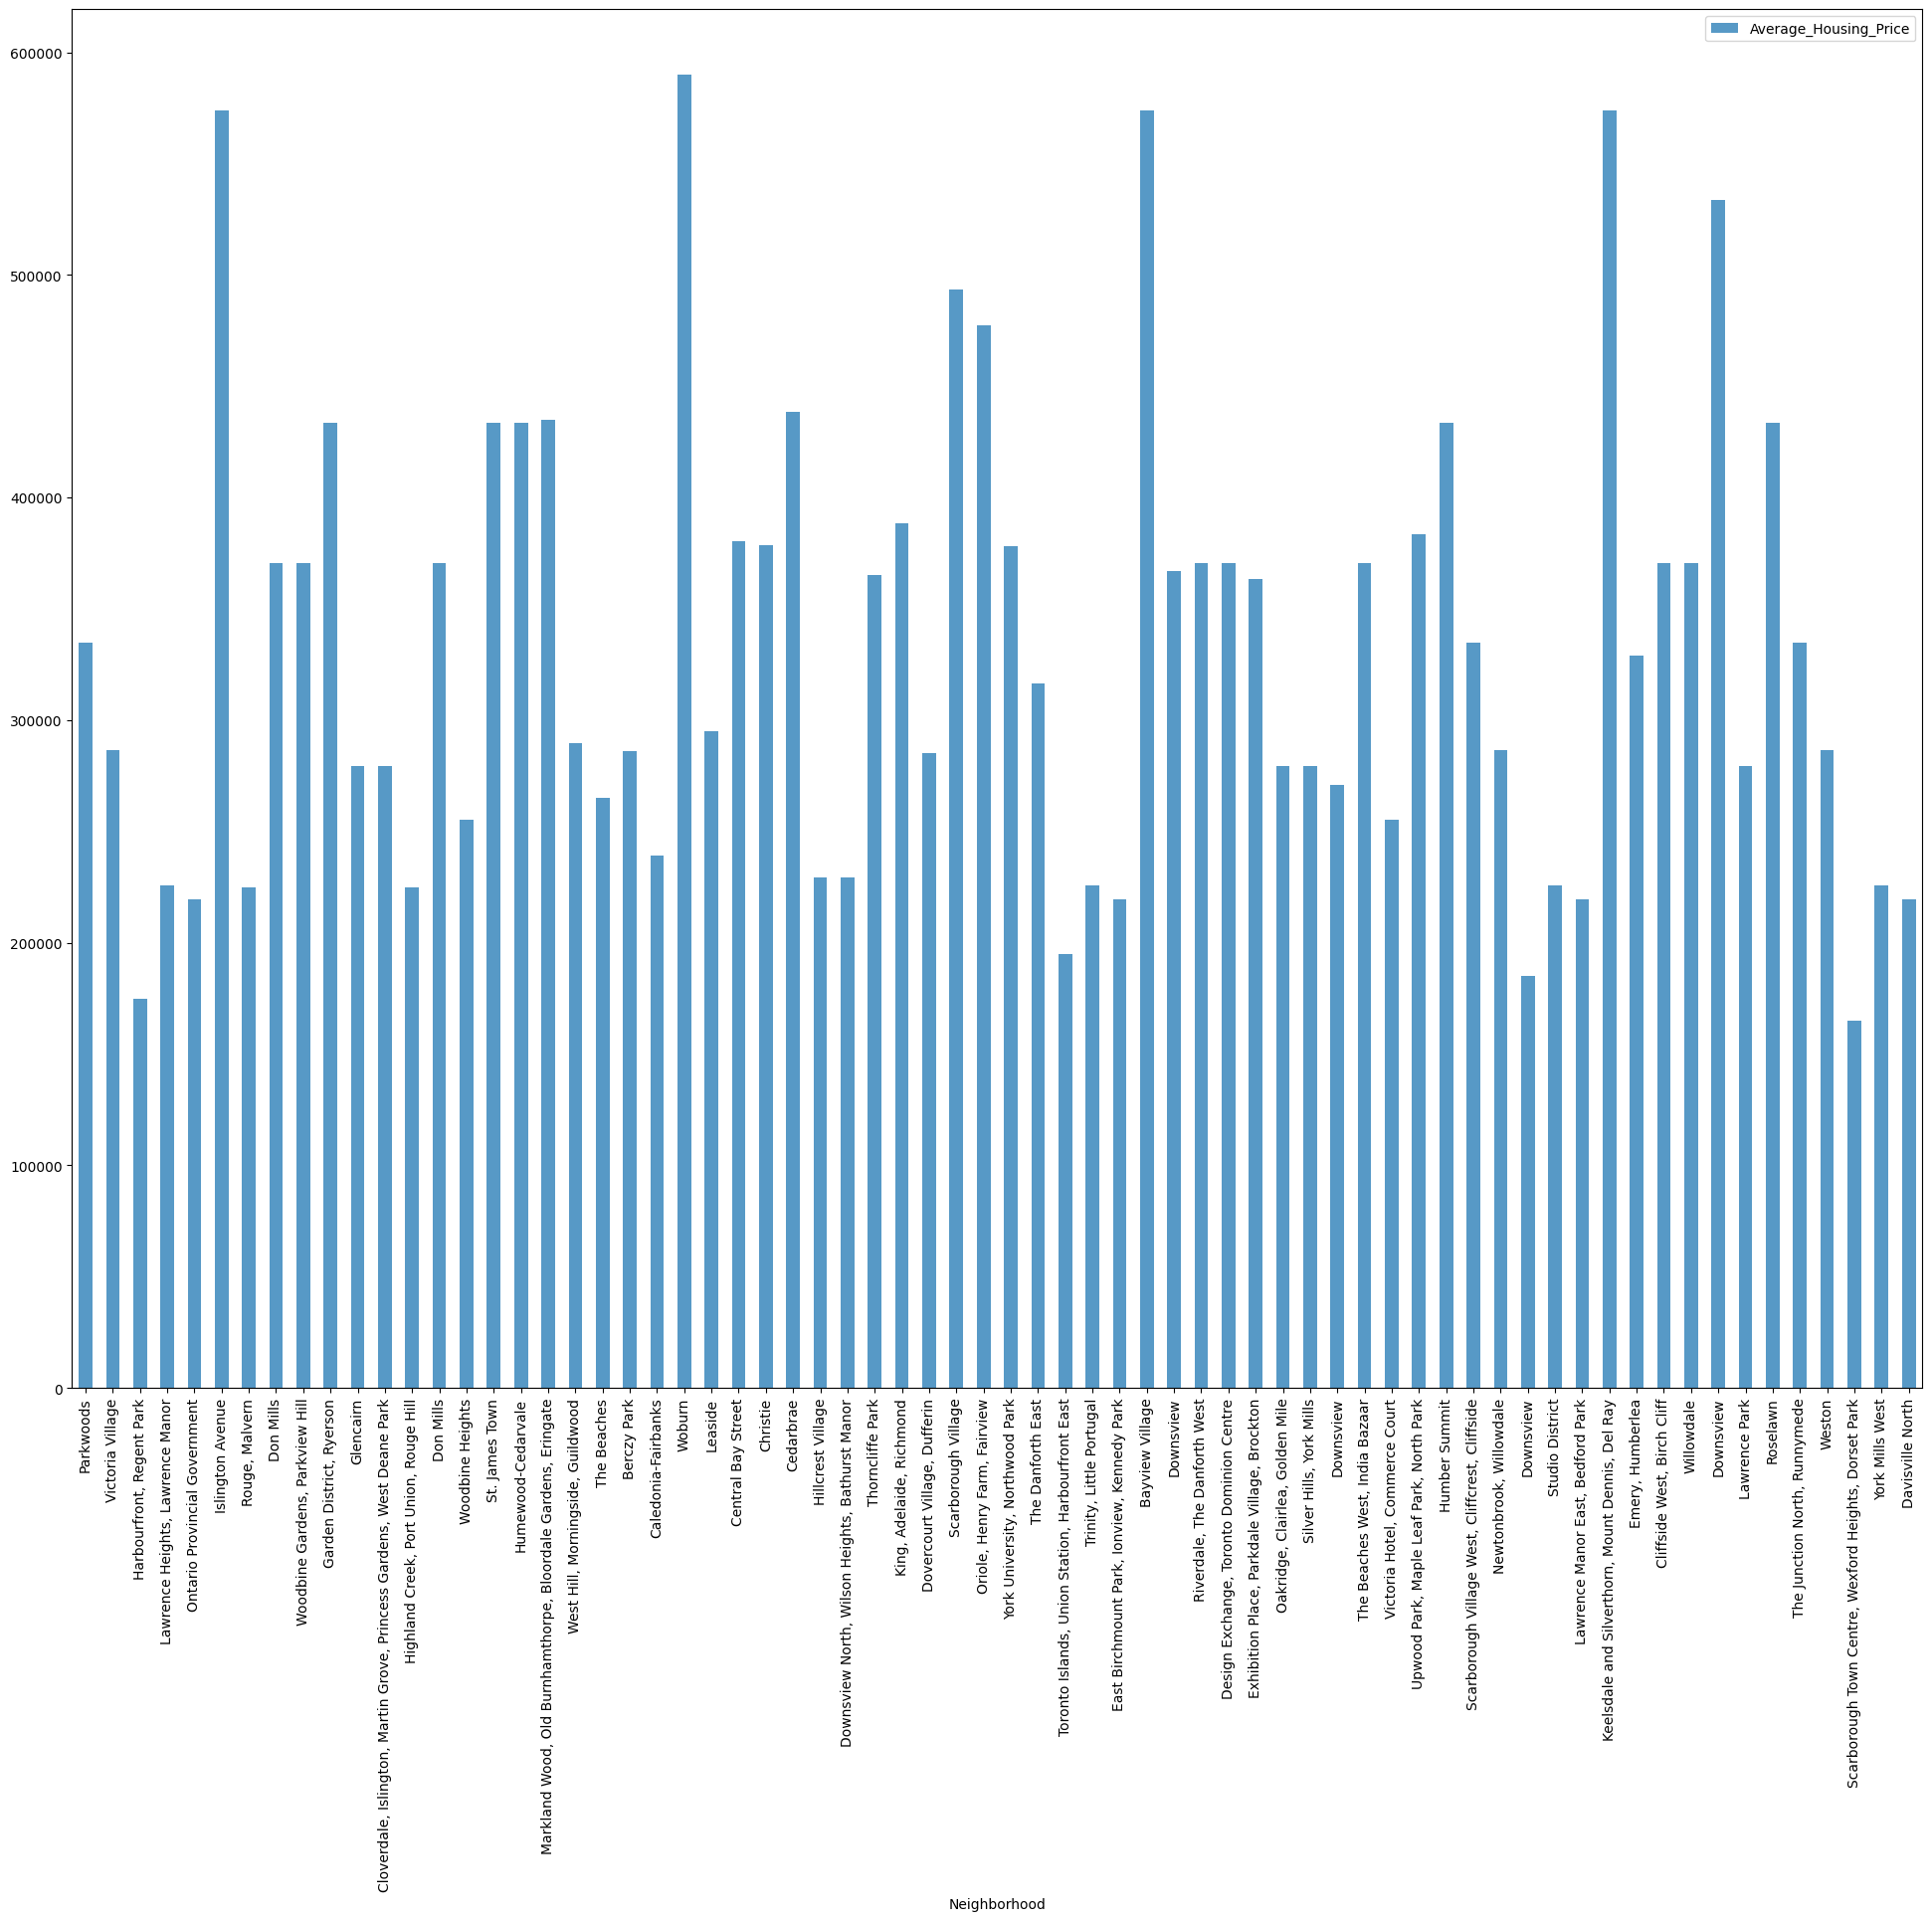

In [ ]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

**School Rating by Clusters**

In [ ]:
clusters=pd.DataFrame({"Cluster1":df4["Neighborhood"],
                      "Cluster2":df4["Neighborhood"],
                      "Cluster4":df6["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [ ]:
new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df1["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
7
]})

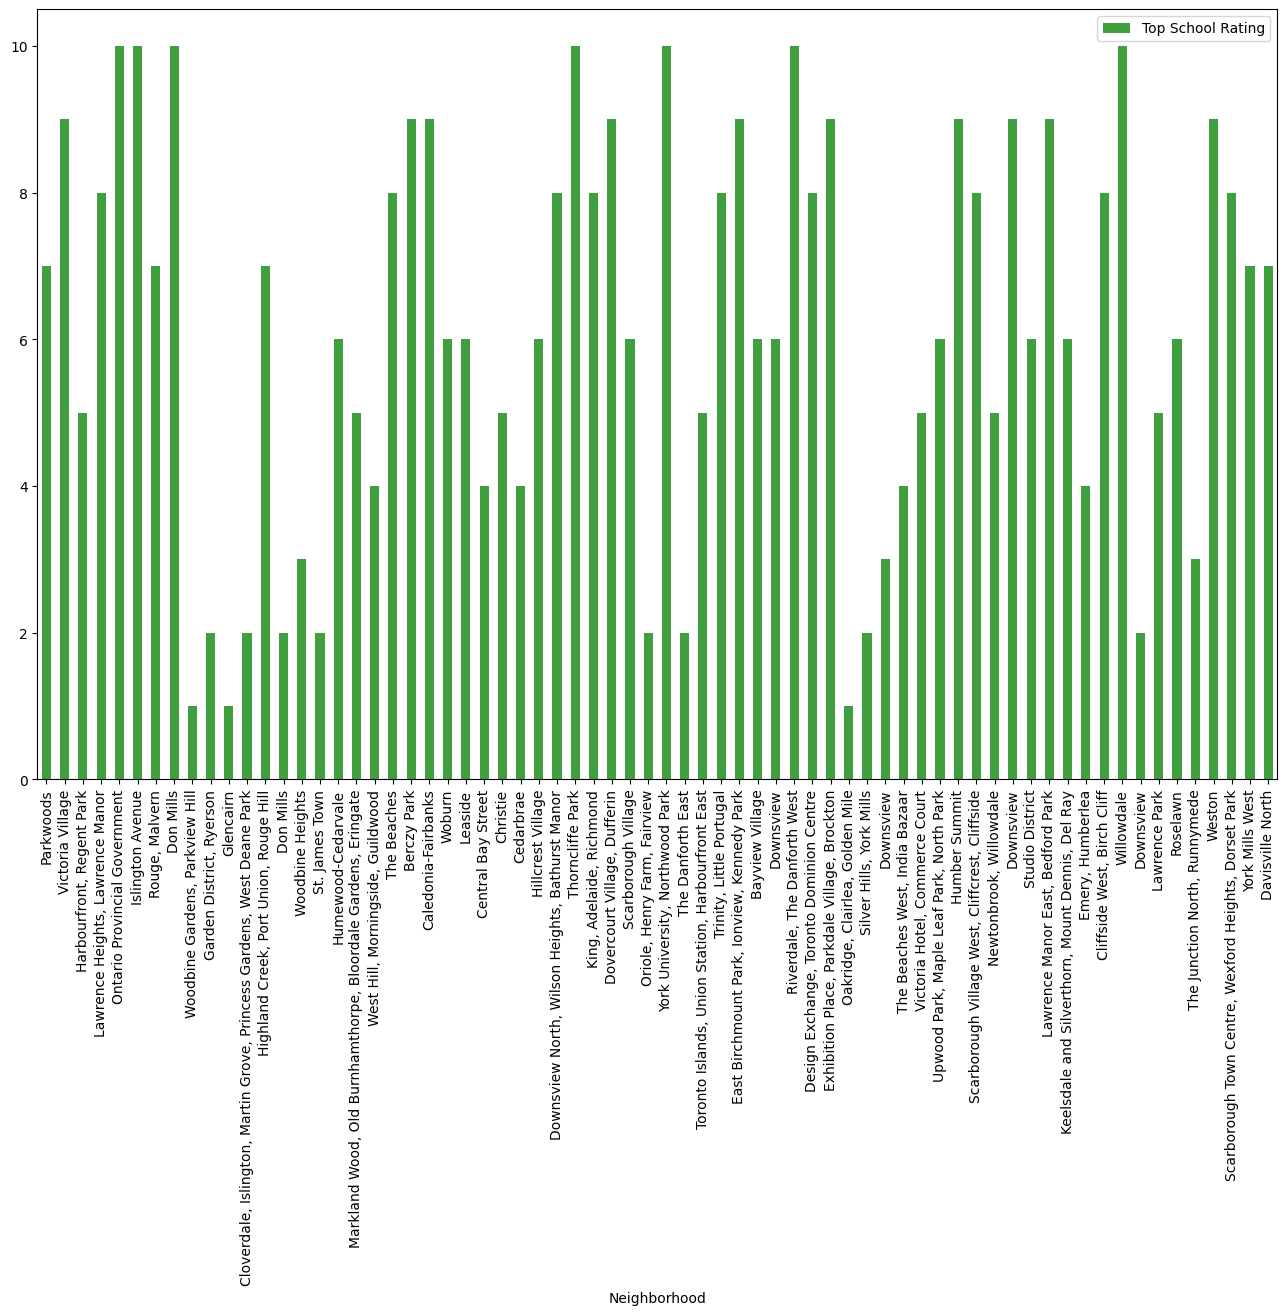

In [ ]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)
Scarborough_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);